**Notes : Penginstalan dengan tanda -q maksudnya adalah mode quiet atau diam sehingga tidak mengeluarkan output saat eksekusi** 

Tahapan pertama sebelum melakukan eksplorasi dan praproses pada data adalah memasukan library yang akan digunakan untuk menganalisa dataset dengan menggunakan metode Deep Learning seperti Neural Network dalam pengolahan teks, Chatbot dll. Library yang saya gunakan yaitu NumPy untuk komputasi matematika, Matplotlib untuk visualisasi model data, Natural Language Toolkit atau NLTK untuk pengolahan teks, Pandas untuk membaca data, serta Tensorflow untuk model pada data menggunakan algoritma LSTM dan Jaringan Syaraf Tiruan (Neural Network).

In [ ]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

Download NLTK Package

In [ ]:
# Package sentence tokenizer
nltk.download('punkt') 
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# 02 Data Acquisition

Setelah kita mengetahui apa saja alur yang digunakan untuk membuat proyek AI Chatbot maka tahapan selanjutnya adalah mengunduh atau download dataset dari GitHub milik Fendy Hendriyanto pada bagian repository AI Chatbot. Link: [Chatbot-AI](https://github.com/fendy07/chatbot-AI)

**Load Dataset Json**

Setelah import library, tahapan selanjutnya adalah me-load dataset yang telah disediakan. Dataset yang digunakan berupa format **.json** yang sangat cocok untuk membuat model Chatbot. 

Data Json merupakan data yang termasuk dalam *semi structured* yang dimana data ini menampung beberapa bagian data seperti **tag**, **pattern**, **context**, dan **response**. Data yang dipakai dalam proyek ini menggunakan dataset manual yang diciptakan oleh student Kampus Merdeka Batch 2 tentang <b>Chatbot Sistem Rekomendasi Kampus Merdeka</b>. [Github](https://github.com/mahmudwhd/WebKadekBot)

In [ ]:
# Importing the dataset
with open('Intent_KM.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [ ]:
# Cetak data keseluruhan
data 

,patterns,tags
0,Hai,salam
1,Hi,salam
2,Halo,salam
3,Selamat Pagi,salam
4,Selamat Siang,salam
...,...,...
253,beda batik tulis dan cetak apa?,perbedaan_batik_tulis_dan_cetak
254,Apa yang dimaksud dengan motif batik Udan Liris?,batik_udan_liris
255,Bagaimana karakteristik motif batik Udan Liris?,batik_udan_liris
256,Jelaskan tentang motif batik Udan Liris.,batik_udan_liris


In [ ]:
# Cetak data baris pertama sampai baris kelima
data.head() 

,patterns,tags
0,Hai,salam
1,Hi,salam
2,Halo,salam
3,Selamat Pagi,salam
4,Selamat Siang,salam


In [ ]:
# Cetak data baris ke-70 sampai baris akhir
data.tail() 

,patterns,tags
253,beda batik tulis dan cetak apa?,perbedaan_batik_tulis_dan_cetak
254,Apa yang dimaksud dengan motif batik Udan Liris?,batik_udan_liris
255,Bagaimana karakteristik motif batik Udan Liris?,batik_udan_liris
256,Jelaskan tentang motif batik Udan Liris.,batik_udan_liris
257,Apa itu Batik Udan Liris?,batik_udan_liris


Data yang telah kita miliki dalam format JSON yang dapat digunakan melalui pandas dengan cara konversi. Data JSON yang saya miliki didapat dengan cara manual dengan mengambil beberapa referensi website tentang program Kampus Merdeka.

# 03 Preprocessing The Data

Setelah kita meload data dan mengonversi data json menjadi dataframe. Tahapan selanjutnya adalah praproses pada dataset yang kita gunakan saat ini yaitu dengan cara:

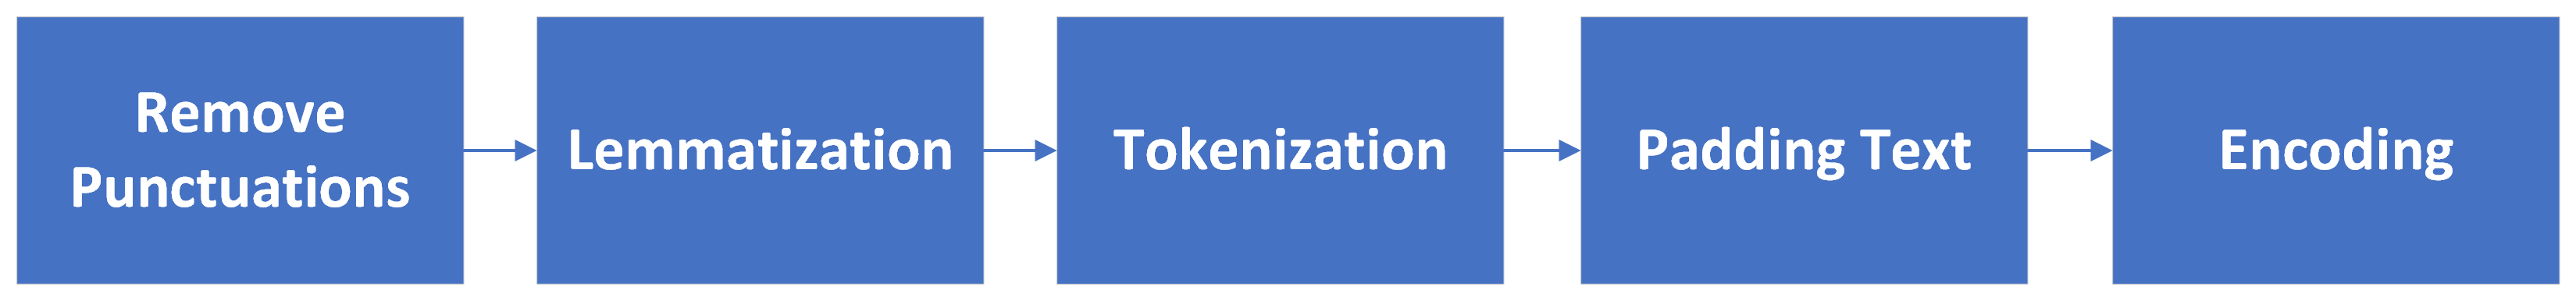

1.   Remove Punctuations (Menghapus Punktuasi)
2.   Lematization (Lematisasi)
3.   Tokenization (Tokenisasi)
4.   Apply Padding (Padding)
5.   Encoding the Outputs (Konversi Keluaran Enkoding)

Kelima tahapan pemrosesan teks ini dijelaskan pada bagian langkah selanjutnya.

## Remove Punctuations

Tahapan praproses pada data teks yang pertama adalah menghapus punktuasi atau tanda baca seperti *special character* yaitu **'!'** (**tanda seru**) **','** (**tanda koma**) **'.'** (**tanda titik sebagai berhenti**) '**?**' (**tanda tanya**) dan tanda baca yang lain. Tahapan ini gunanya untuk mempermudah pemrosesan data teks yang akan kita olah.

In [ ]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

## Lemmatization (Lematisasi)

Setelah menghapus punktuasi atau tanda baca, tahapan selanjutnya yaitu Lematisasi atau Lemmatization. **Apa itu Lematisasi?**

Lematisasi atau Lemmatization adalah proses dimana merujuk pada melakukan sesuatu menggunakan vocabulary atau kosakata dan analisis morfologi kata-kata untuk menghilangkan *inflectional endings only* dan untuk mengembalikan bentuk *dictionary* (kata dalam kamus) dari sebuah kata yang dikenal sebagai ***lemma***. 

Contoh Lematisasi : **Menggunakan** (Kata Imbuhan) -> **Guna** (Kata Dasar) 

Dalam contoh berikut proses lematisasi awalnya data teks menggunakan kata imbuhan yaitu **Menggunakan** dimana **meng-** + **guna** (kata dasar yang berawalan vokal g) + **kan** (sebagai akhiran) diubah menjadi kata dasar yaitu '**Guna**'. 

Proses ini dimana menghilangkan Prefiks pada imbuhan (**Meng-**) dan Suffiks pada (**-kan**).

In [ ]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

210 unique lemmatized words ['.', 'ada', 'adalah', 'agar', 'aja', 'algoritma', 'antara', 'apa', 'apakah', 'asli', 'aslinya', 'atau', 'autentisitas', 'bagaimana', 'bagimana', 'bali', 'bantu', 'banyak', 'bapeda', 'batik', 'beda', 'bedanya', 'beli', 'berapa', 'berasal', 'berkelanjutan', 'betawi', 'bisa', 'bisakah', 'bisanya', 'boleh', 'bot', 'buat', 'budaya', 'bye', 'cap', 'cara', 'celup', 'ceplok', 'cetak', 'ciamis', 'ciri-ciri', 'cnn', 'dab', 'dadah', 'daerah', 'dalam', 'dan', 'dapat', 'dari', 'dayak', 'dengan', 'desain', 'deteksi', 'di', 'dianggap', 'dibandingkan', 'dibuat', 'dicetak', 'digunakan', 'dilakukan', 'dimaksud', 'diminati', 'dipakai', 'diperlukan', 'encim', 'era', 'fashion', 'fungsi', 'ga', 'garutan', 'generasi', 'gimana', 'goodbye', 'gunanya', 'hai', 'halo', 'hanya', 'hi', 'identitas', 'indonesia', 'industri', 'ini', 'interior', 'itu', 'jawa', 'jelaskan', 'jenis', 'jumpa', 'kain', 'kamu', 'karakteristik', 'kasih', 'kawung', 'keaslian', 'keberlanjutan', 'kenapa', 'keraton', 

### Menyortir Data Kelas Tags

In [ ]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

54 classes ['Asal_Batik', 'Batik Kombinasi', 'Batik_Bali', 'Batik_Betawi', 'Batik_Celup', 'Batik_Ciamis', 'Batik_Dayak', 'Batik_Garutan', 'Batik_Kawung', 'Batik_Keraton', 'Batik_Lasem', 'Batik_Megamendung', 'Batik_Pala', 'Batik_Parang', 'Batik_Pekalongan', 'Batik_Poleng', 'Batik_Priangan', 'Batik_Sekar', 'Batik_Sidoluhur', 'Batik_Sogan', 'Merawat_batik', 'Noda_kotoran_batik', 'Teknik_pewarnaan_batik', 'batik', 'batik_cap', 'batik_ceplok', 'batik_encim', 'batik_lereng', 'batik_lereng_wijilan', 'batik_nitik', 'batik_truntum', 'batik_udan_liris', 'beda_batik', 'buat_batik', 'cnn', 'fungsi', 'goodbye', 'industri_batik_berkelanjutan', 'jenis_batik', 'manfaat_batik', 'menjaga_keaslian_batik', 'model', 'nama', 'penggunaan_batik', 'peran_generasi_muda', 'perbedaan_batik_jawa_sumatra', 'perbedaan_batik_tulis_dan_cetak', 'proses_malam', 'salam', 'simbol_identitas_budaya', 'teknik_batik_tulis', 'terkenal', 'thanks', 'warna_batik']


### Mencari Jumlah Keseluruhan Data Teks

In [ ]:
# documents = combination between patterns and intents
print (len(documents), "documents")

1332 documents


## Tokenization (Tokenisasi)

Setelah proses lematisasi dan mencari tahu data classes dan jumlah keseluruhan data patterns dengan intents-nya. Maka, tahapan selanjutnya proses tokenisasi. **Apa itu Tokenisasi?**

Tokenisasi adalah suatu proses memberikan urutan karakter dan sebuah unit dokumen terdefinisi. Tokenisasi juga merupakan tugas untuk memecah kalimat menjadi bagian-bagian yang disebut dengan '**Token**' dan menghilangkan bagian tertentu seperti tanda baca.

Contohnya: **Aku Pergi Ke Makassar** -> '**Aku**' '**Pergi**' '**Ke**' '**Makassar**'

In [ ]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[126],
 [127],
 [128],
 [57, 129],
 [57, 130],
 [57, 29],
 [131],
 [92, 132],
 [57, 133],
 [134],
 [135],
 [92, 136, 137],
 [93, 73],
 [138],
 [139],
 [140, 74],
 [93, 73, 75],
 [141, 142],
 [48, 13, 49],
 [48, 94, 49],
 [94, 49, 10],
 [143, 49],
 [13, 4, 2],
 [49, 75],
 [2, 48, 13],
 [13, 144, 48, 145],
 [146, 73, 21, 48, 13, 75],
 [95, 96, 4, 2, 10],
 [13, 26, 2],
 [2, 3, 97, 95, 96, 147],
 [13, 148, 2],
 [149, 13, 2, 10],
 [1, 4, 2, 10],
 [150, 1, 2],
 [1, 98],
 [2, 3, 6, 5, 1],
 [1, 151, 58, 76, 77],
 [1, 152, 58, 76, 77],
 [1, 153, 154, 58, 76, 77],
 [2, 17, 22, 1, 3, 99, 50, 59],
 [1, 3, 99, 50, 59, 2, 17],
 [1, 3, 100, 50, 59, 2, 17],
 [2, 17, 22, 1, 3, 101],
 [22, 1, 101, 2, 102],
 [1, 4, 2, 102, 10],
 [1, 22, 2, 3, 100, 50, 59],
 [22, 1, 3, 155, 74, 156, 2],
 [157, 1, 4, 2],
 [7, 8, 51, 1],
 [103, 1, 4, 9, 10],
 [103, 1, 9],
 [8, 51, 1, 9],
 [2, 60, 61, 1, 52, 18, 1, 53],
 [78, 1, 53, 18, 52],
 [2, 158, 1, 52, 3, 159, 5, 1, 53],
 [7, 104, 105, 79, 1, 3, 104, 160, 52, 161, 53]

## Add Padding

Setelah memproses tokenisasi yang dimana memecah kalimat menajdi bagian-bagian yang disebut token yang digunakan untuk mengolah data teks pada AI Chatbot maka tahapan selanjutnya adalah Padding.
**Apa itu Padding?**

**Padding** adalah Suatu proses untuk mengubah setiap sequence agar memiliki panjang yang sama. Pada padding, setiap sequence dibuat sama panjang dengan menambahkan nilai 0 secara suffiks atau prefiks hingga mencapai panjang maksimum sequence. Selain itu padding juga dapat memotong sequence hingga panjangnya sesuai dengan panjang maksimum sequence. 

Padding juga adalah proses untuk membuat setiap kalimat pada teks memiliki panjang yang seragam. Sama seperti melakukan resize gambar, agar resolusi setiap gambar sama besar. Untuk menggunakan padding bisa impor library **pad_sequence**. Kemudian buat panggil fungsi pad_sequence() dan masukkan sequence hasil tokenisasi sebagai parameternya.

Contohnya: `sequences_samapanjang = pad_sequences(sequences)`

Yang nantinya akan dikeluarkan menjadi angka dengan awalan 0 seperti gambar dibawah ini.

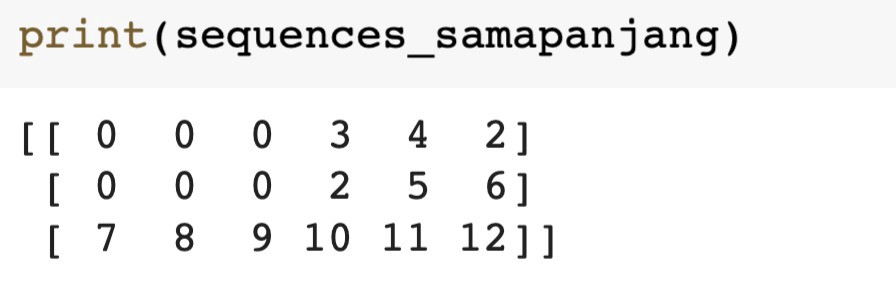

In [ ]:
# Apply padding 
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0 126]
 [  0   0   0 ...   0   0 127]
 [  0   0   0 ...   0   0 128]
 ...
 [  0   0   0 ...   1  71  72]
 [  0   0   0 ...   1  71  72]
 [  0   0   0 ...   1  71  72]]


Hasil setelah padding adalah setiap sequence memiliki panjang yang sama. Padding dapat melakukan ini dengan menambahkan 0 secara default pada awal sequence yang lebih pendek.

## Encoding Text

Setelah tahapan proses Padding pada suatu teks maka proses terakhir dalam pemrosesan teks adalah tahapan Encoding. **Apa itu Encoding?**

Encoding merupakan suatu konversi atau pengkodean yang dimana data kategorik seperti huruf atau data teks menjadi data numerik atau angka menyesuaikan dengan data label yang digunakan. Pada proses tahapan ini, encoding mengubah data teks pada kolom data tags menjadi data numerik dengan bahasa biner komputer yaitu 0 dan 1. 

Tujuan dari encoding ini adalah mempermudah saat proses komputasi data teks dan modelling.

In [ ]:
# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train) #Label Encodings

[48 48 48 48 48 48 36 36 36 36 36 36 52 52 52 52 52 52 42 42 42 42 42 42
 42 42 42 35 35 35 35 35 23 23 23 23  0  0  0 51 51 51 38 38 38 38 38 38
 33 33 33 33 32 32 32 32 32 41 41 41 41 41 34 34 39 39 39 16 16 16 16 16
 16  6  6  6  6  6  6  7  7  7  7  7  7  9  9  9  9  9  9 19 19 19 19 19
 19  8  8  8  8  8  8 18 18 18 18 18 18 10 10 10 10 10 10 17 17 17 17 17
 17 13 13 13 13 13 13 14 14 14 14 14 14 11 11 11 11 11 11  2  2  2  2  2
  2  5  5  5  5  5  5  4  4  4  4  4  4 15 15 15 15 15 15  3  3  3  3  3
  3 12 12 12 12 12 12 53 53 53 20 20 20 21 21 21 21  1  1  1  1  1 22 22
 22 22 26 26 26 49 49 49 47 47 47 47 47 43 43 43 43 40 40 40 27 27 27 27
 37 37 37 44 44 44 29 29 29 29 50 50 50 50 45 45 45 45 24 24 24 24 25 25
 25 25 30 30 30 30 28 28 28 28 46 46 46 46 31 31 31 31]


Tokenizer pada Tensorflow memberikan token unik untuk setiap kata yang berbeda. Dan juga padding dilakukan untuk mendapatkan semua data dengan panjang yang sama sehingga dapat mengirimkannya ke lapisan atau layer RNN. variabel target juga dikodekan menjadi nilai desimal.

# 04 Input Length, Output Length and Vocabulary



In [ ]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

12


In [ ]:
# Define vocabulary
vocabulary = len(tokenizer.word_index)
print("Number of unique words: ", vocabulary)

# Output length
output_length = le.classes_.shape[0]
print("Output length: ", output_length)



Number of unique words:  209
Output length:  54


In [ ]:
max_sequence_length = max(len(seq) for seq in train)
print("Max sequence length:", max_sequence_length)


Max sequence length: 12


**Input length** dan **output length** terlihat sangat jelas hasilnya. Mereka adalah untuk bentuk input dan bentuk output dari data train atau latih yang akan diproses pada algoritma Neural Network atau Jaringan Syaraf Tiruan.

**Vocabulary Size** adalah untuk lapisan penyematan untuk membuat representasi vektor unik untuk setiap kata.

## Save Model Words & Classes

Setelah dilakukan pemrosesan teks yang dilakukan lima tahap maka kita bisa simpan model pemrosesan teks tersebut dengan menggunakan format pickle. 

Hal ini biasanya digunakan untuk membuat hubungan model yang telah dilatih dengan model pemrosesan teks. 

In [ ]:
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

## Save Label Encoder & Tokenizer

In [ ]:
pickle.dump(le, open('le.pkl','wb'))
pickle.dump(tokenizer, open('tokenizers.pkl','wb'))

# 05 Neural Network Model (LSTM)

Setelah menyimpan model untuk pemrosesan teks, tahapan selanjutnya adalah melakukan modelling untuk Chatbot dengan menggunakan algoritma Neural Network atau Jaringan Syaraf Tiruan dengan algoritma LSTM (Long Short Term Memory). **Apa itu Algoritma LSTM?**

**LSTM (Long Short Term Memory)** merupakan algoritma Deep Learning yang populer dan cocok digunakan untuk membuat prediksi dan klasifikasi yang berhubungan dengan waktu dan data teks. 

Algoritma ini bisa dikatakan pengembangan atau salah satu jenis dari algoritma RNN (Recurrent Neural Network). Dalam algoritma RNN, output dari langkah terakhir diumpankan kembali sebagai input pada langkah yang sedang aktif. Namun, algoritma RNN memiliki kekurangan yaitu tidak dapat memprediksi kata yang disimpan dalam memori jangka panjang.

Nah, algoritma LSTM dirancang untuk mengatasi kelemahan tersebut, namun tetap mempertahankan kelebihan yang ada pada algoritma RNN dimana RNN mampu memberikan prediksi yang lebih akurat dari informasi terbaru.

Algoritma LSTM pertama kali dikembangkan oleh Hochreiter dan Schmidhuber.  Algoritma ini mampu menyimpan informasi untuk jangka waktu yang lama. Hal ini kemudian dapat digunakan untuk memproses, memprediksi, dan mengklasifikasikan informasi berdasarkan data deret waktu.

Struktur algoritma LSTM terdiri atas neural network dan beberapa blok memori yang berbeda. Blok memori ini disebut sebagai cell.  State dari cell dan hidden state akan diteruskan ke cell berikutnya.

Seperti yang ditunjukkan pada gambar di bawah, bangun berbentuk persegi panjang berwarna biru adalah **ilustrasi cell** pada LSTM.

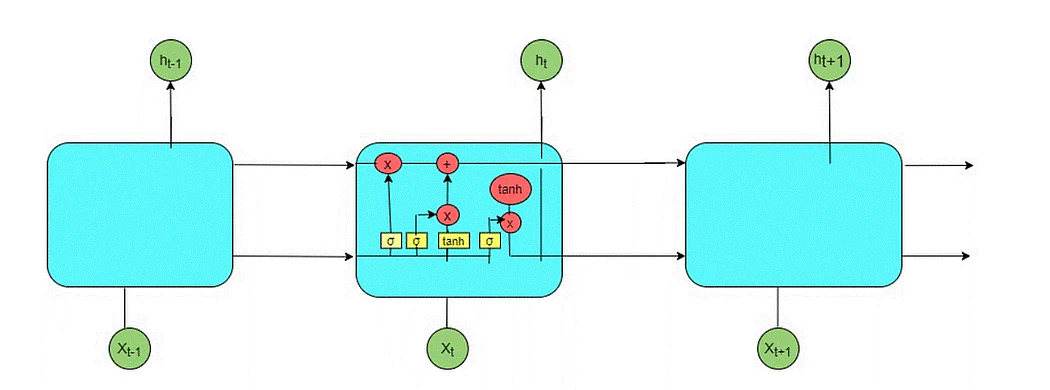

Informasi yang dikumpulkan oleh algoritma LSTM kemudian akan disimpan oleh cell dan manipulasi memori dilakukan oleh komponen yang disebut dengan gate. Ada tiga jenis gate pada algoritma LSTM, di antaranya  Forget gate, Input gate, dan  Output gate. Sumber : [Trivusi](https://www.trivusi.web.id/2022/07/algoritma-lstm.html)

Jaringan syaraf dalam kasus chatbot ini yang terdiri dari lapisan atau *layer* embedding yang merupakan salah satu hal yang paling kuat di bidang pemrosesan bahasa alami atau NLP. output atau keluaran dari lapisan (*layer*) embedding adalah input (masukan) data teks dari lapisan berulang (*recurrent*) dengan layer LSTM gate (Lapisan Gerbang **Long Shot Term Memory)**. Kemudian, output atau keluaran diratakan dan lapisan Dense digunakan dengan fungsi aktivasi **Softmax** yang dimana implementasi chatbot ini memiliki data label lebih dari dua kelas.

Bagian utama dalam pemodelan chatbot ini adalah lapisan embedding yang memberikan nilai vektor yang sesuai untuk setiap kata dalam data teks yang telah dimasukkan.

In [ ]:
# Creating the model (Membuat Modeling)
i = Input(shape=(max_sequence_length,))

x = Embedding(vocabulary+1, 10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model = Model(i, x)

# Compiling the model (Kompilasi Model)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # Mengubah learning rate
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['accuracy']) # Menggunakan optimizer yang telah ditentukan


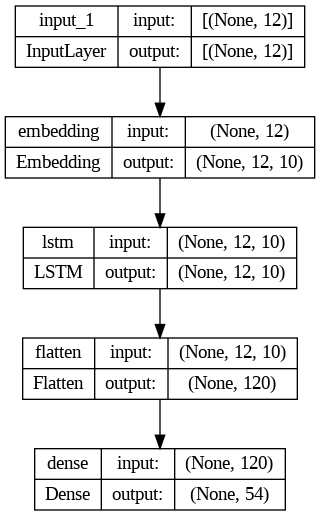

In [ ]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Menampilkan Parameter Model
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 embedding (Embedding)       (None, 12, 10)            2100      
                                                                 
 lstm (LSTM)                 (None, 12, 10)            840       
                                                                 
 flatten (Flatten)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 54)                6534      
                                                                 
Total params: 9,474
Trainable params: 9,474
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model (Latih model data sampai 4000 kali)
train = model.fit(x_train, y_train, epochs=4000)

Streaming output truncated to the last 5000 lines.
9/9 [==============================] - 0s 7ms/step - loss: 4.7258e-06 - accuracy: 1.0000
Epoch 1502/4000
9/9 [==============================] - 0s 6ms/step - loss: 4.6949e-06 - accuracy: 1.0000
Epoch 1503/4000
9/9 [==============================] - 0s 6ms/step - loss: 4.6750e-06 - accuracy: 1.0000
Epoch 1504/4000
9/9 [==============================] - 0s 6ms/step - loss: 4.7614e-06 - accuracy: 1.0000
Epoch 1505/4000
9/9 [==============================] - 0s 6ms/step - loss: 4.7531e-06 - accuracy: 1.0000
Epoch 1506/4000
9/9 [==============================] - 0s 7ms/step - loss: 4.7184e-06 - accuracy: 1.0000
Epoch 1507/4000
9/9 [==============================] - 0s 7ms/step - loss: 4.6602e-06 - accuracy: 1.0000
Epoch 1508/4000
9/9 [==============================] - 0s 7ms/step - loss: 4.5849e-06 - accuracy: 1.0000
Epoch 1509/4000
9/9 [==============================] - 0s 7ms/step - loss: 4.5553e-06 - accuracy: 1.0000
Epoch 1510/4000
9/9 

# 06 Model Analysis

Setelah menjalankan pelatihan model dengan algoritma Neural Neural dan LSTM serta telah mengetahui hasil akurasi pada step terakhir. Maka, tahapan selanjutnya adalah menganalisa model dengan visualisasi plot akurasi dan loss untuk melihat hasil akurasi dari algoritma pelatihan model Neural Network dengan LSTM tersebut.

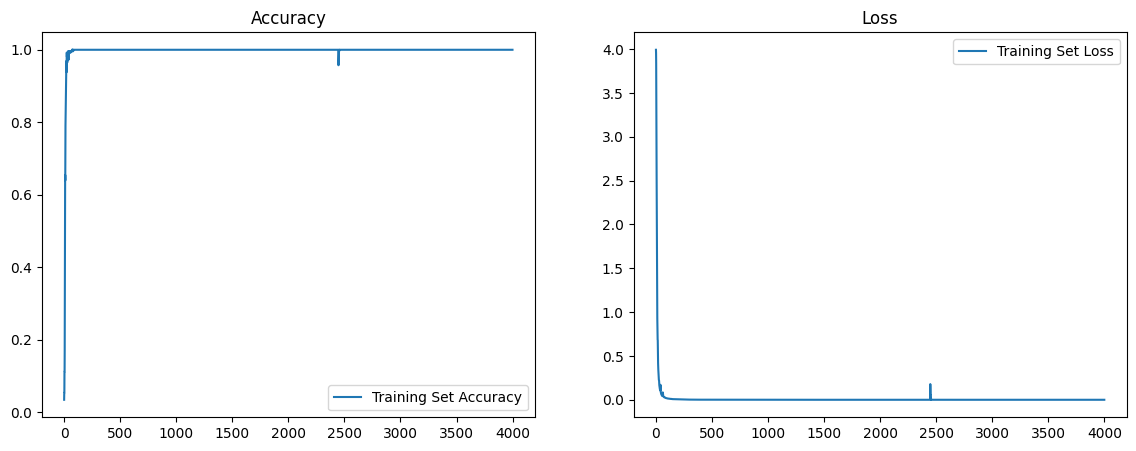

In [ ]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

Terlihat bahwa model pelatihan chatbot dengan algoritma Neural Network + LSTM menghasilkan model yang baik dan tidak terjadi overfitting atau underfitting. Sehingga, model ini layak dilakukan pengujian dan evaluasi model chatbot yang diperoleh.

# 07 Testing Chatbot Dan Tambahkan Suara Pada Chatbot

Setelah mengetahui hasil dari akurasi dan loss pada model yang telah ditetapkan dengan algoritma Neural Network dan LSTM. Maka, tahapan selanjutnya adalah menguji atau testing pada chatbot yang telah dilatih sebelumnya dan melihat apakah sesuai atau tidak pada saat kita masukan teks kalimat pertanyaannya. 

Pada pengujian ini menggunakan metode input atau masukan sesuai dengan kalimat pertanyaan yang dimasukkan.

In [ ]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag
  response_tag = le.inverse_transform([output])[0]
  print("🤖 Bapeda\Bot : ", random.choice(responses[response_tag]))
  print("="*60 + "\n")

  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "goodbye":
    break


👨‍🦰 Kamu : apa yang dimaksud dengan batik pala
1/1 [==============================] - 0s 19ms/step
🤖 Bapeda\Bot :  Batik Pala adalah salah satu jenis batik tradisional Indonesia yang berasal dari daerah Pala, Aceh. Motif Batik Pala biasanya terinspirasi oleh keindahan alam Aceh seperti pohon pinus, bunga raflesia, atau burung enggang. Warna yang umumnya digunakan pada batik Pala adalah warna-warna alam seperti cokelat, hijau, hitam, dan putih. Teknik pembuatan Batik Pala menggunakan teknik tulis dan cap yang dilakukan oleh pengrajin batik yang sangat terampil di Aceh. Batik Pala sering kali digunakan sebagai bahan untuk busana tradisional Aceh seperti baju kurung atau sarung. Untuk mengenal Batik Pala, Anda dapat memperhatikan motif-motif yang digunakan pada kain batik. Batik Pala memiliki keunikan dan keindahan tersendiri sehingga sangat dihargai di Aceh dan di seluruh Indonesia.

👨‍🦰 Kamu : apa itu proses malam pada batik
1/1 [==============================] - 0s 18ms/step
🤖 Bapeda\B

# 08 Save The Model

Setelah pengujian Chatbot telah disesuaikan dengan kalimat dan jawabannya. Maka, model chatbot bisa disimpan dengan format .h5 atau .pkl (pickle) untuk penggunaan aplikasi AI Chatbot dengan website atau sistem Android. Penyimpanan file model bisa langsung secara transient atau bisa taruh di Google Drive.

In [ ]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
model.save('chatbot_model.h5')

print('Model Saved Successfully!')

Model Saved Successfully!
